## ДЗ №1
Распознать изображение с игральными картами и вывести изображение и номинал каждой карты

http://farm4.staticflickr.com/3828/9060450367_b67ef44444_o_d.png

1. Прочитайте изображение из файла и выведите его на экран:

In [154]:
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
import cv2

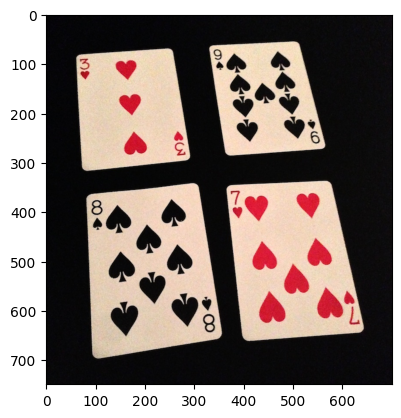

In [155]:
image = imread('http://farm4.staticflickr.com/3828/9060450367_b67ef44444_o_d.png')
plt.imshow(image)

In [156]:
image.shape

(749, 700, 4)

2. Выполните последоватьельно 2 преобразования: переведите изображение в оттенки серого (COLOR_BGR2GRAY) и примените размытие (GaussianBlur):

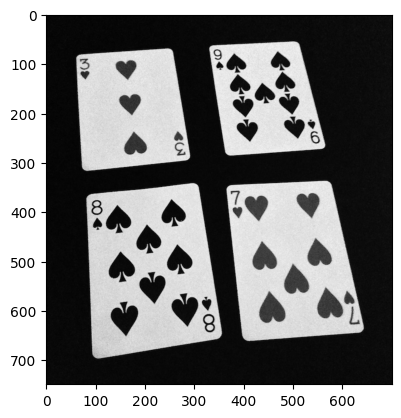

In [157]:
def to_grey(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


grey = to_grey(image)
plt.imshow(grey, cmap='gray')

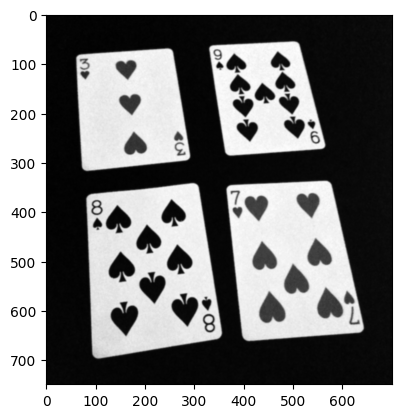

In [158]:
def blur(image):
    return cv2.GaussianBlur(image, (5, 5), 0)


blurred = blur(grey)
plt.imshow(blurred, cmap='gray')

In [159]:
def get_largest_contours(contours, area_ratio_threshold):
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
    largest_area = cv2.contourArea(sorted_contours[0])
    largest_contours = [sorted_contours[0]]
    for contour in sorted_contours[1:]:
        if cv2.contourArea(contour) / largest_area > area_ratio_threshold:
            largest_contours.append(contour)
    return largest_contours

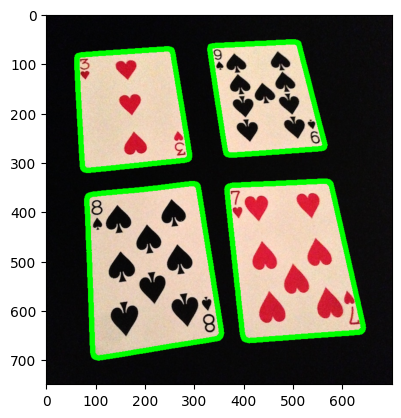

In [160]:
#cards_count = 4

def find_contours(image_to_find_contours, image_to_return, area_ratio_threshold=0.5):
    flag, threshold = cv2.threshold(image_to_find_contours, 128, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    #contours = sorted(contours, key=cv2.contourArea, reverse=True)[:cards_count]
    contours = get_largest_contours(contours, area_ratio_threshold=area_ratio_threshold)

    contours_img = image_to_return.copy()
    cv2.drawContours(contours_img, contours, contourIdx = -1, color = (0, 255, 0, 255), thickness = 10)
    return contours_img, contours

contours_image, contours = find_contours(blurred, image)
plt.imshow(contours_image)

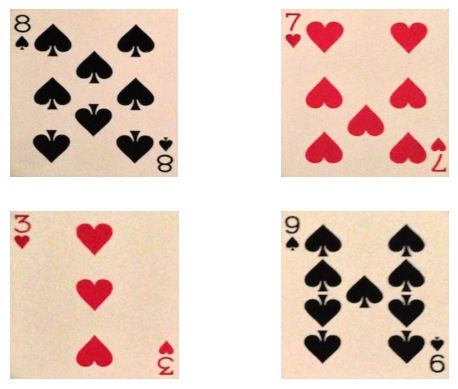

In [161]:
def extract_cards(image, contours):
    result = []
    for card in contours:
        #card = contours[i]
        perimeter = cv2.arcLength(card, True)
        approximated_curve = np.array(cv2.approxPolyDP(card, 0.02 * perimeter, True), np.float32)
        #bounding_rectangle = cv2.minAreaRect(contours[2])
        #bounding_rectangle = cv2.minAreaRect(contours[i])
        #r = cv2.boxPoints(bounding_rectangle)
        h = np.array([[0,0],[450, 0],[450, 450],[0, 450]], np.float32)
        transform = cv2.getPerspectiveTransform(approximated_curve, h)
        warp = cv2.warpPerspective(image,transform,(450, 450))[:, ::-1]
        result.append(warp)
        #plt.subplot(2,2,i+1); plt.axis('off')
        #plt.imshow(warp)

    return result


extracted_cards = extract_cards(image, contours)

for i, card in enumerate(extracted_cards):
    plt.subplot(2, 2, i + 1)
    plt.axis('off')
    plt.imshow(card)

plt.show()

5. Найдите количество символов на одной карте:
- на изображение карты найдите все контуры;
- найдите максимальный контур (не совпадающий с самой картой);
- найдите другие контуры, отличающиеся от максимального по размеру не более 10%;
- посчитайте количество максимальных контуров.

Номинал карты:  8


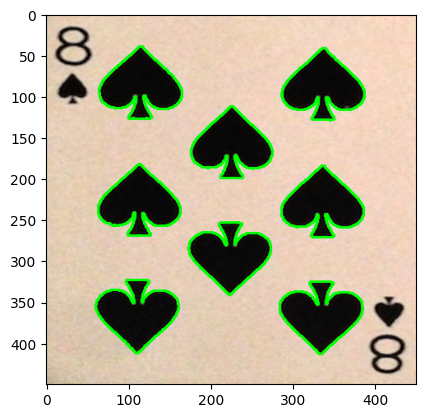

In [162]:
def find_symbols_on_card(card):
    img_gray = cv2.cvtColor(card, cv2.COLOR_RGB2GRAY)
    contours_img = card.copy()

    flag, thresh = cv2.threshold(img_gray, 128, 255, cv2.THRESH_BINARY) # !!! ПОДОБРАТЬ ЗНАЧЕНИЯ ПАРАМЕТРОВ ВМЕCТО ТОЧЕК
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # card_suit_contours = []
    # sample_suit_contour_area = 0
    # for contour in contours:
    #     if cv2.contourArea(contour) > 0.9 * card.shape[0] * card.shape[1]:
    #         continue
    #     if sample_suit_contour_area == 0:
    #         card_suit_contours.append(contour)
    #         sample_suit_contour_area = cv2.contourArea(contour)
    #     else:
    #         if abs(cv2.contourArea(contour) - sample_suit_contour_area) < sample_suit_contour_area * 0.1:
    #             card_suit_contours.append(contour)
    card_suit_contours = get_largest_contours(contours[1:], area_ratio_threshold=0.9)

    card_suit_contours_found = len(card_suit_contours)

    cv2.drawContours(contours_img, card_suit_contours, contourIdx=-1, color=(0, 255, 0, 255), thickness = 2)
    return contours_img, card_suit_contours_found


image_with_found_symbols, card_suit_contours_found = find_symbols_on_card(extracted_cards[0])
print('Номинал карты: ', card_suit_contours_found)
plt.imshow(image_with_found_symbols)

6. Соберите все предыдущие команды в один код, чтобы на выходе получилось следующее изображение

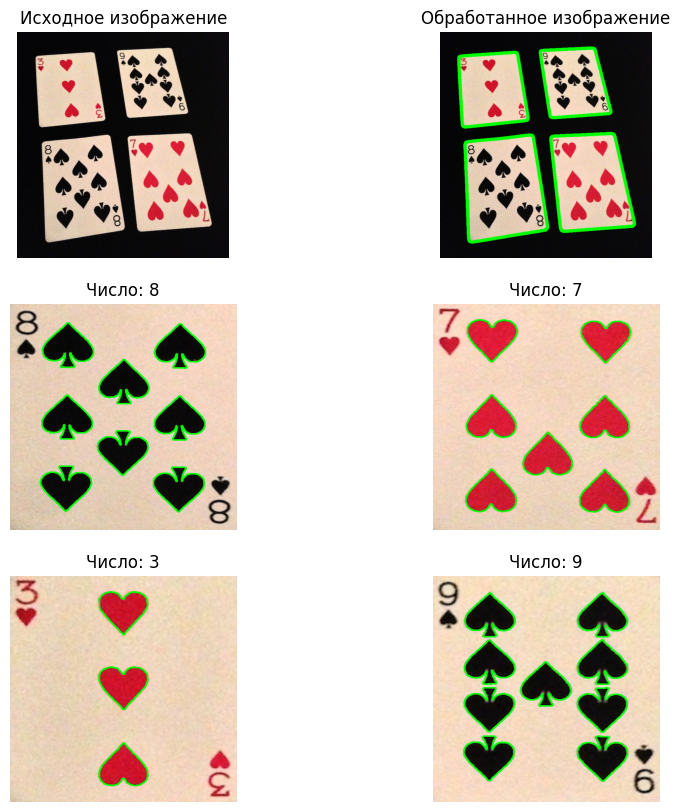

In [183]:
from math import ceil


image = imread('http://farm4.staticflickr.com/3828/9060450367_b67ef44444_o_d.png')

grey = to_grey(image)
blurred = blur(grey)
contours_image, contours = find_contours(blurred, image)
cards_count = len(contours)

plt.figure(figsize=(10, 10))

columns = 2
rows = ceil(cards_count / 2) + 1

plt.subplot(rows, columns, 1)
plt.imshow(image)
plt.axis('off')
plt.title('Исходное изображение')



plt.subplot(rows, columns, 2)
plt.imshow(contours_image)
plt.axis('off')
plt.title('Обработанное изображение')

extracted_cards = extract_cards(image, contours)
find_symbols_output = map(find_symbols_on_card, extracted_cards)
for i, (image_with_found_symbols, card_suit_contours_found) in enumerate(find_symbols_output):
    plt.subplot(rows, columns, 3 + i)
    plt.imshow(image_with_found_symbols)
    plt.axis('off')
    plt.title(f'Число: {card_suit_contours_found}')

## ДЗ №2
Подумайте, что нужно изменить, чтобы код сработал для этого изображения:

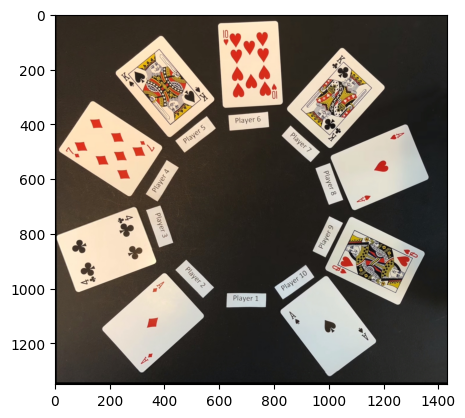

In [164]:
image = imread('cards.png')
plt.imshow(image)

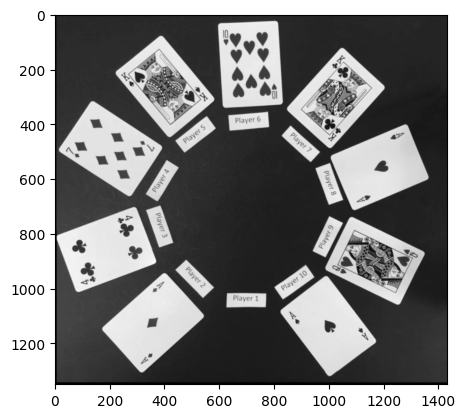

In [165]:
grey = to_grey(image)
blurred = blur(grey)
plt.imshow(blurred, cmap='gray')

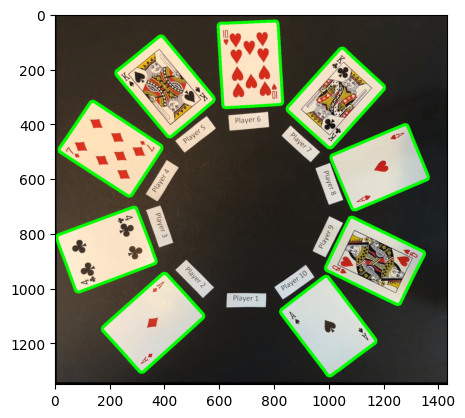

In [166]:
contours_image, contours = find_contours(blurred, image)
plt.imshow(contours_image)

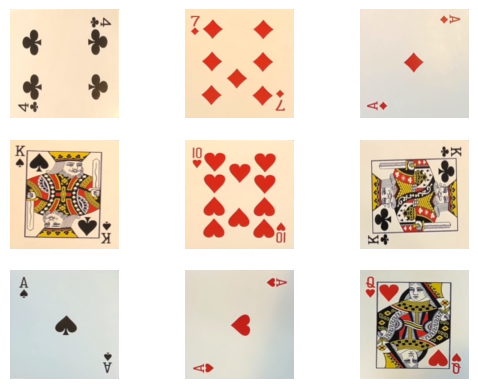

In [172]:
extracted_cards = extract_cards(image, contours)
for i, card in enumerate(extracted_cards):
    plt.subplot(3, 3, i + 1)
    plt.axis('off')
    plt.imshow(card)

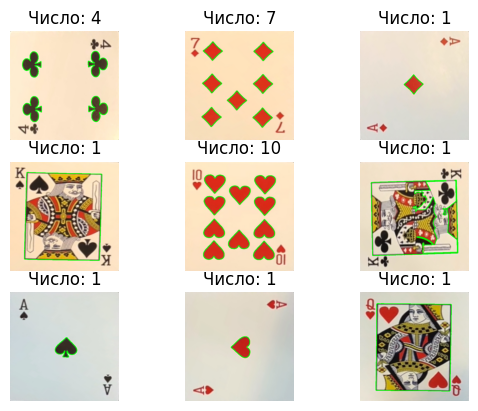

In [180]:
find_symbols_output = map(find_symbols_on_card, extracted_cards)
for i, (image_with_found_symbols, card_suit_contours_found) in enumerate(find_symbols_output):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image_with_found_symbols)
    plt.axis('off')
    plt.title(f'Число: {card_suit_contours_found}')